# Testing Regularization on CIFAR10 with LeNet

## Imports and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary

from data_generators import data_loader_MNIST
from model_classes import ResNet, ResidualBlock, LeNet, MLP
from tools import accuracy, plot_results, plot_jacobi_results, svb

c:\Users\aslak\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Loading MNIST dataset
in_channels = 1
train_loader, test_loader = data_loader_MNIST()
summary_model = LeNet(lr=0.01, momentum=0.9, in_channels=in_channels).to(device)
summary(summary_model, (in_channels, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


## Train function

In [4]:
def train(
    dl,
    model,
    n_epochs=2,
    l1=False,
    l1_lmbd=0.00001,
    l2=False,
    l2_lmbd=0.0001,
    soft_svb=False,
    soft_svb_lmbd=0.01,
    hard_svb=False,
    hard_svb_lmbd=0.001,
    jacobi_reg=False,
    jacobi_reg_lmbd=0.001, jacobi_det_reg=False, jacobi_det_reg_lmbd=0.001
):
    losses = []
    epochs = []
    weights = []
    accuracies = []
    jacobi_losses = []
    
    for epoch in range(n_epochs):
        N = len(dl)
        for param in model.parameters():
            weights.append(param.detach().numpy().copy())
        for i, (data, labels) in enumerate(dl):
            epochs.append(epoch + i / N)
            if jacobi_reg or jacobi_det_reg:
                loss_data, jacobi_loss_data = model.train_step(
                    data,
                    labels,
                    l1=l1,
                    l1_lmbd=l1_lmbd,
                    l2=l2,
                    l2_lmbd=l2_lmbd,
                    soft_svb=soft_svb,
                    soft_svb_lmbd=soft_svb_lmbd,
                    jacobi_reg=jacobi_reg,
                    jacobi_reg_lmbd=jacobi_reg_lmbd, jacobi_det_reg=jacobi_det_reg, jacobi_det_reg_lmbd=jacobi_det_reg_lmbd
                )
                losses.append(loss_data)
                if jacobi_loss_data is not None:
                    jacobi_losses.append(jacobi_loss_data)
                else:
                    jacobi_losses.append(0)
            else:
                loss_data = model.train_step(
                    data,
                    labels,
                    l1=l1,
                    l1_lmbd=l1_lmbd,
                    l2=l2,
                    l2_lmbd=l2_lmbd,
                    soft_svb=soft_svb,
                    soft_svb_lmbd=soft_svb_lmbd,
                )
                losses.append(loss_data)

        if hard_svb:
            svb(model, eps=hard_svb_lmbd)

        acc = accuracy(model, test_loader)
        accuracies.append(acc)
        model.counter = 0
        print(f"Epoch: {epoch}")
        print("Accuracy of the network on the test images: %d %%" % (100 * acc))

    if jacobi_reg or jacobi_det_reg:
        return losses, jacobi_losses, epochs, weights, accuracies
    return losses, epochs, weights, accuracies


## Hyperparameters

In [5]:
lr = 0.01
momentum = 0.9


## No regularization

In [6]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 2
losses, epochs, weights, accuracies = train(train_loader, model, n_epochs)


Epoch: 0
Accuracy of the network on the test images: 28 %
Epoch: 1
Accuracy of the network on the test images: 73 %


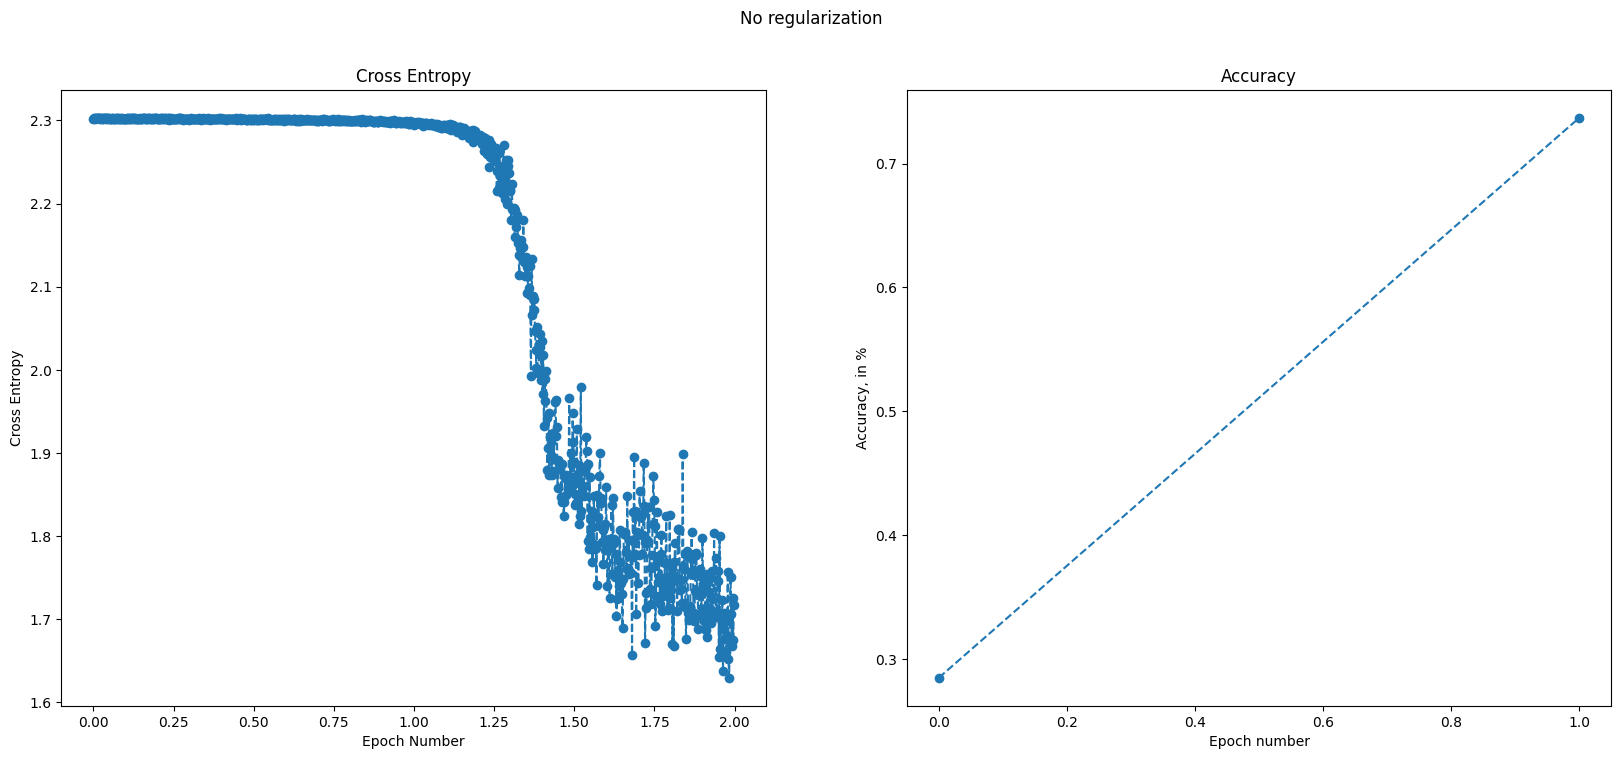

In [7]:
plot_results(epochs, losses, accuracies, title="No regularization")


## L1 Regularization

In [10]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 10
losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, l1=True, l1_lmbd=0.0001
)


KeyboardInterrupt: 

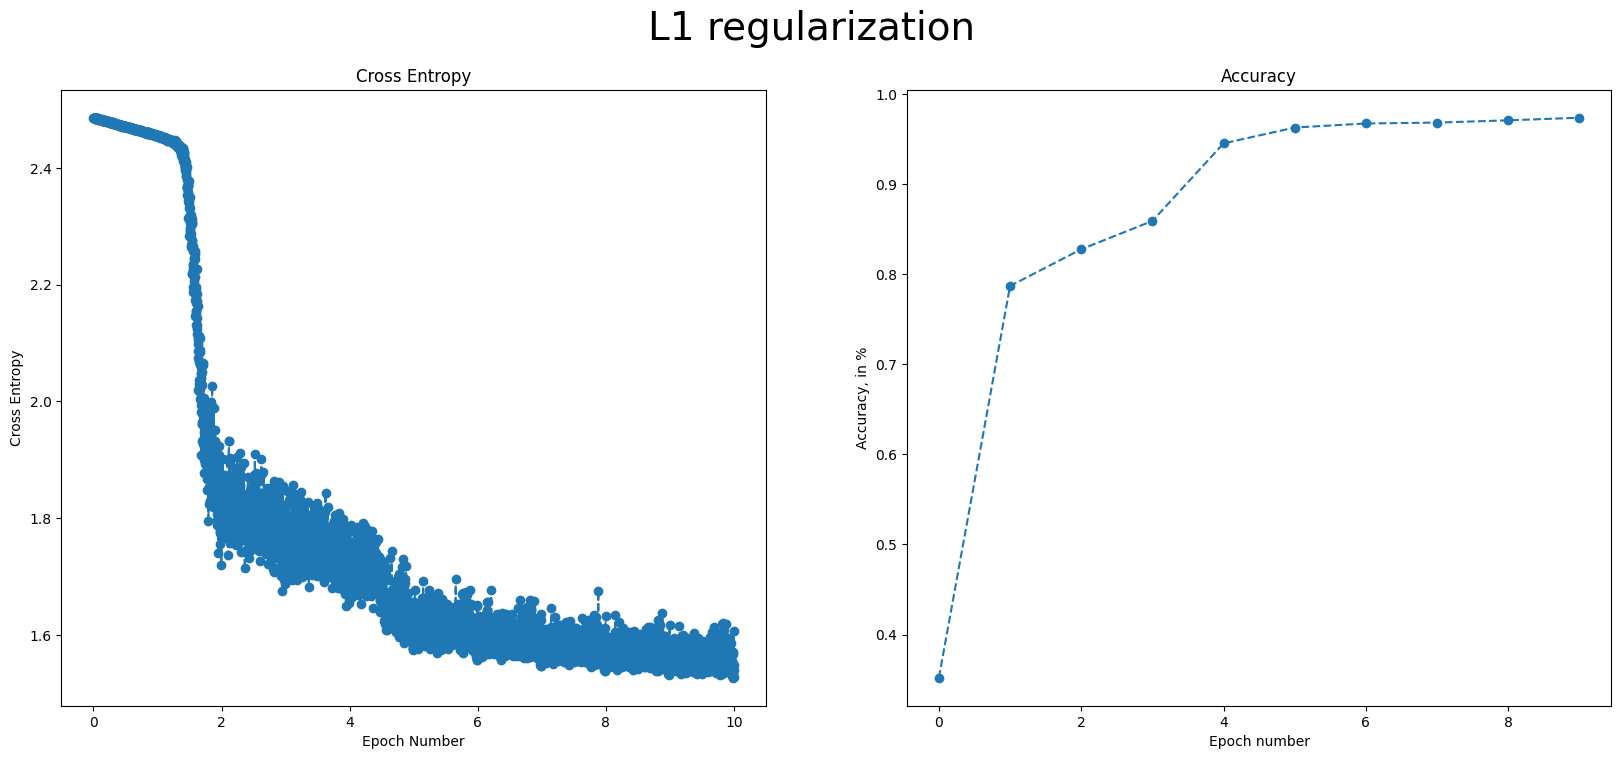

In [9]:
plot_results(epochs, losses, accuracies, title="L1 regularization")


## L2 Regularization

In [22]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 10
losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, l2=True, l2_lmbd=0.001
)


Epoch: 0
Accuracy of the network on the test images: 14 %
Epoch: 1
Accuracy of the network on the test images: 58 %
Epoch: 2
Accuracy of the network on the test images: 74 %
Epoch: 3
Accuracy of the network on the test images: 77 %
Epoch: 4
Accuracy of the network on the test images: 78 %
Epoch: 5
Accuracy of the network on the test images: 87 %
Epoch: 6
Accuracy of the network on the test images: 88 %
Epoch: 7
Accuracy of the network on the test images: 88 %
Epoch: 8
Accuracy of the network on the test images: 88 %
Epoch: 9
Accuracy of the network on the test images: 96 %


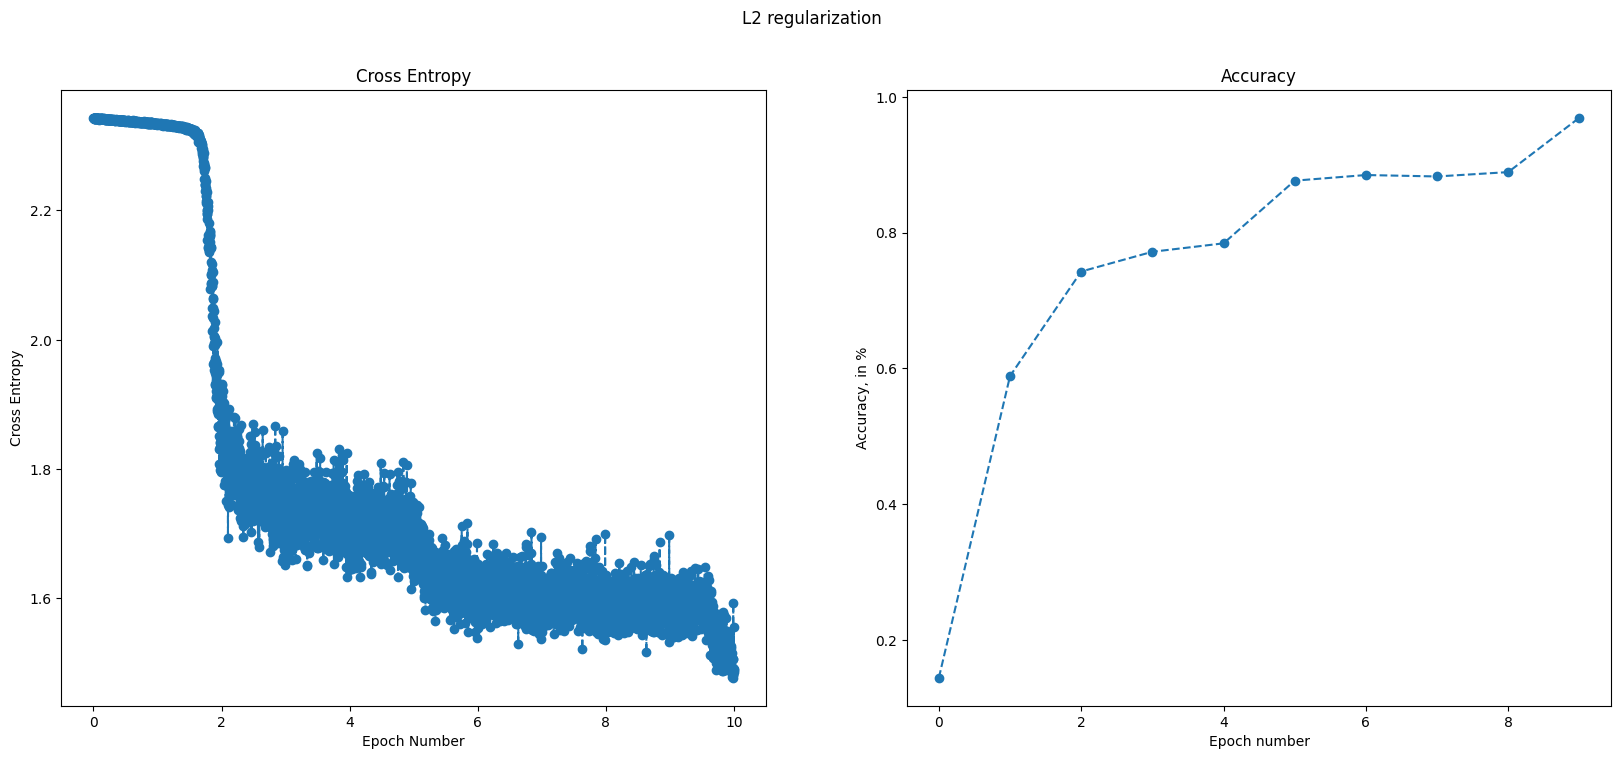

In [23]:
plot_results(epochs, losses, accuracies, title="L2 regularization")


## L1 and L2 Regularization

In [12]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 2
losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, l1=True, l1_lmbd=0.00001, l2=True, l2_lmbd=0.0001
)


Epoch: 0
Accuracy of the network on the test images: 19 %
Epoch: 1
Accuracy of the network on the test images: 65 %


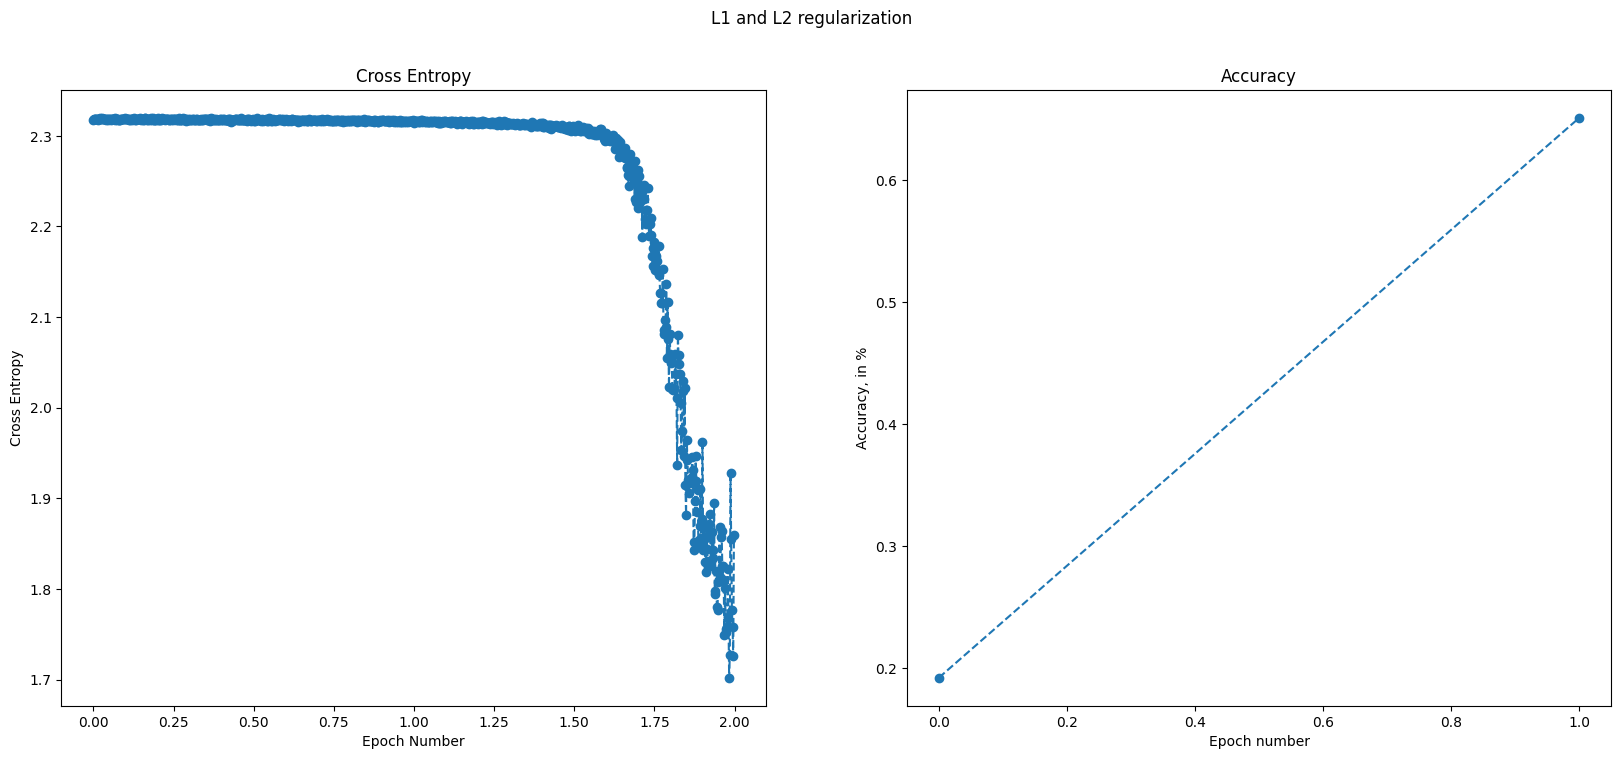

In [13]:
plot_results(epochs, losses, accuracies, title="L1 and L2 regularization")


## Soft SVB Regularization

In [14]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 2
losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, soft_svb=True, soft_svb_lmbd=0.01
)
print(len(epochs))

Epoch: 0
Accuracy of the network on the test images: 17 %
Epoch: 1
Accuracy of the network on the test images: 83 %
938


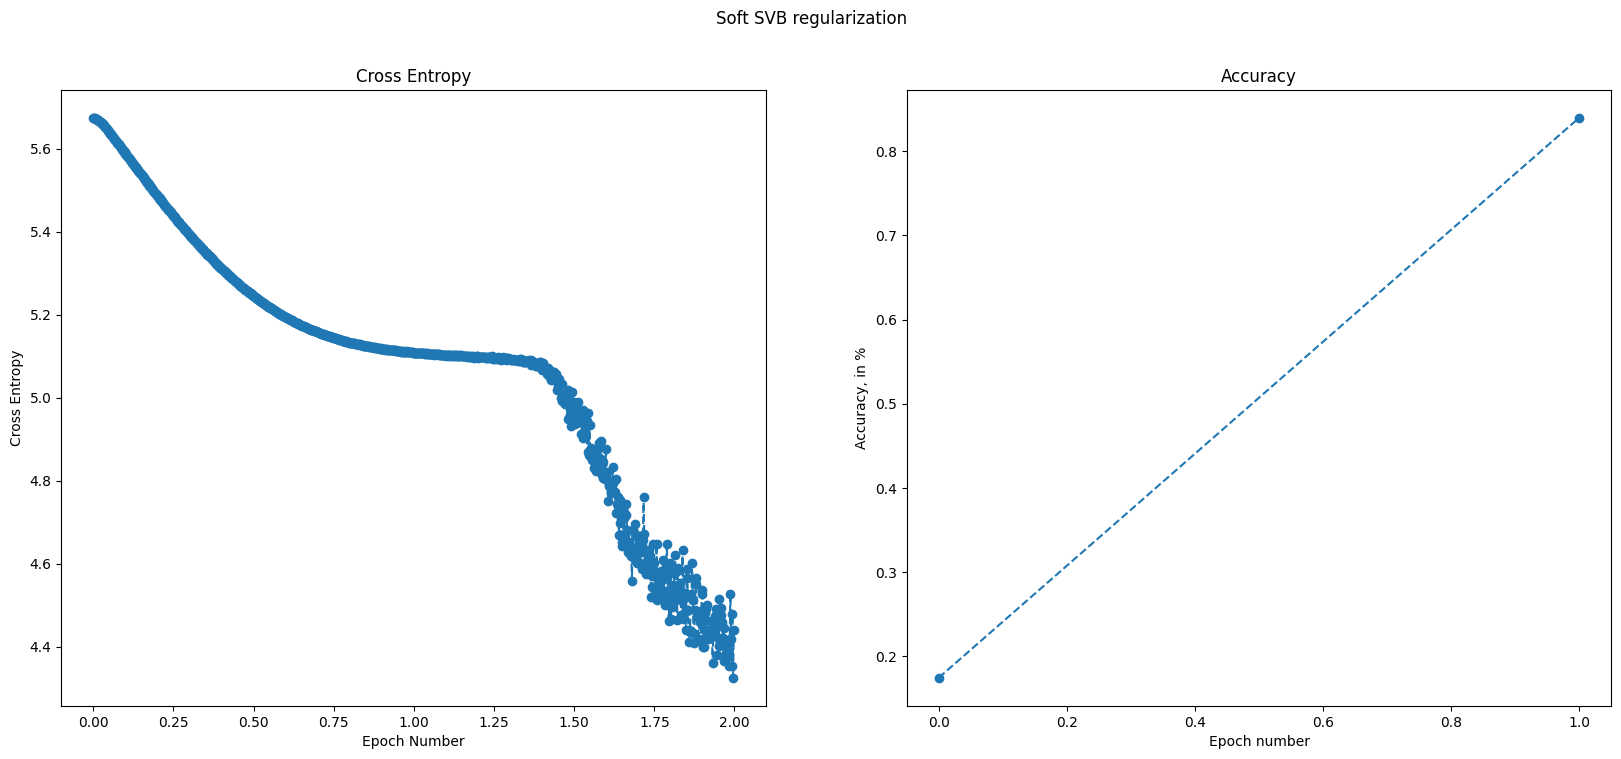

In [15]:
plot_results(epochs, losses, accuracies, title="Soft SVB regularization")


## Hard SVB Regularization

In [16]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 10
losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, hard_svb=True, hard_svb_lmbd=0.001
)


Epoch: 0
Accuracy of the network on the test images: 16 %
Epoch: 1
Accuracy of the network on the test images: 73 %
Epoch: 2
Accuracy of the network on the test images: 83 %
Epoch: 3
Accuracy of the network on the test images: 93 %
Epoch: 4
Accuracy of the network on the test images: 94 %
Epoch: 5
Accuracy of the network on the test images: 96 %
Epoch: 6
Accuracy of the network on the test images: 96 %
Epoch: 7
Accuracy of the network on the test images: 97 %
Epoch: 8
Accuracy of the network on the test images: 97 %
Epoch: 9
Accuracy of the network on the test images: 97 %


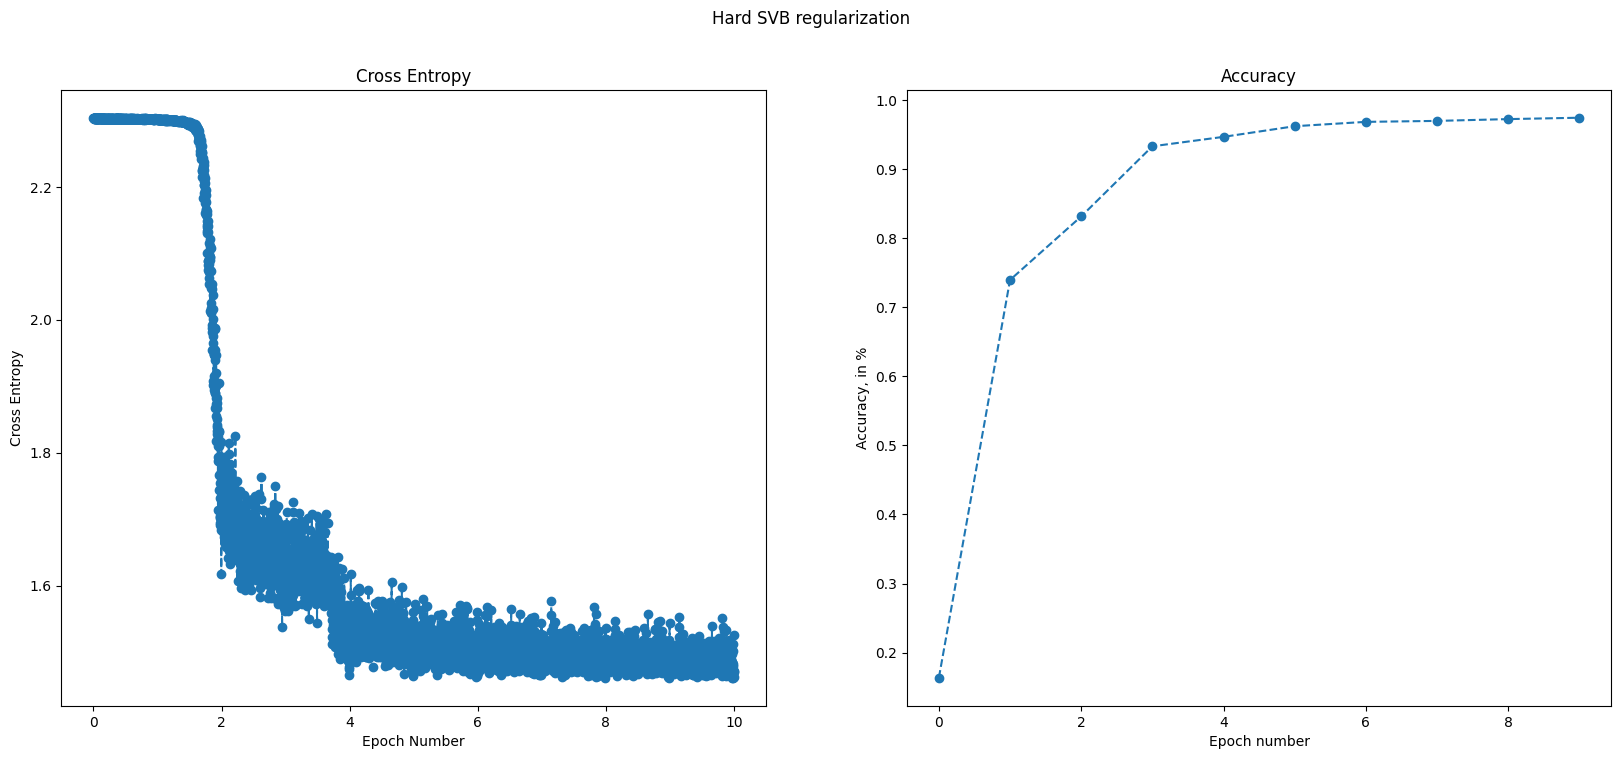

In [17]:
plot_results(epochs, losses, accuracies, title="Hard SVB regularization")


## Jacobi Regularization

In [18]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 2
losses, jacobi_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, jacobi_reg=True, jacobi_reg_lmbd=0.001
)

calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 0
Accuracy of the network on the test images: 11 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 1
Accuracy of the network on the test images: 35 %


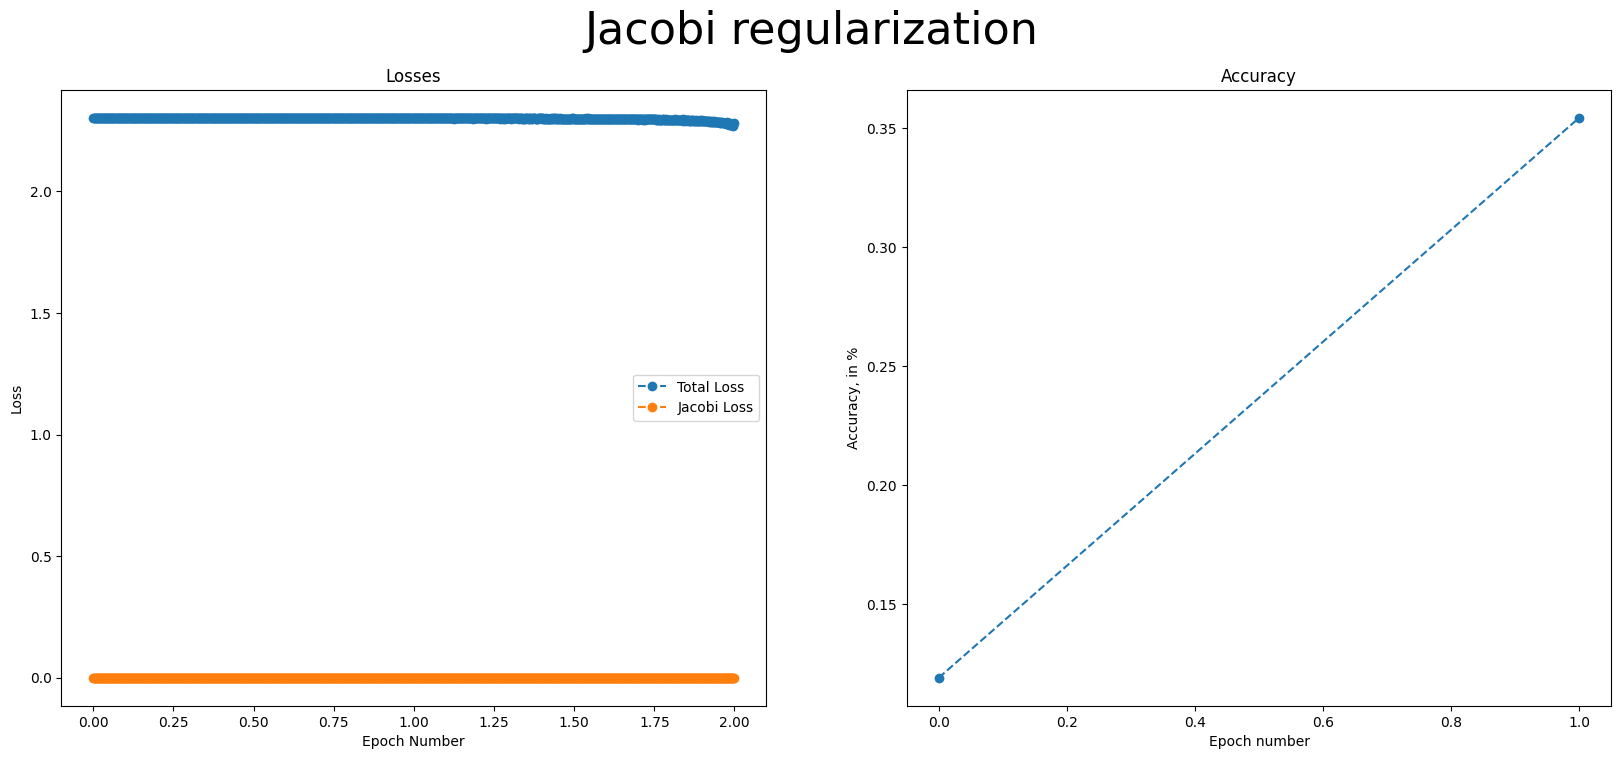

In [19]:
plot_jacobi_results(epochs, losses, jacobi_losses, accuracies, title="Jacobi regularization")

## Jacobi Determinant Regularization

In [20]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 2
losses, jacobi_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, jacobi_det_reg=True, jacobi_det_reg_lmbd=0.001
)

calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 0
Accuracy of the network on the test images: 11 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 1
Accuracy of the network on the test images: 24 %


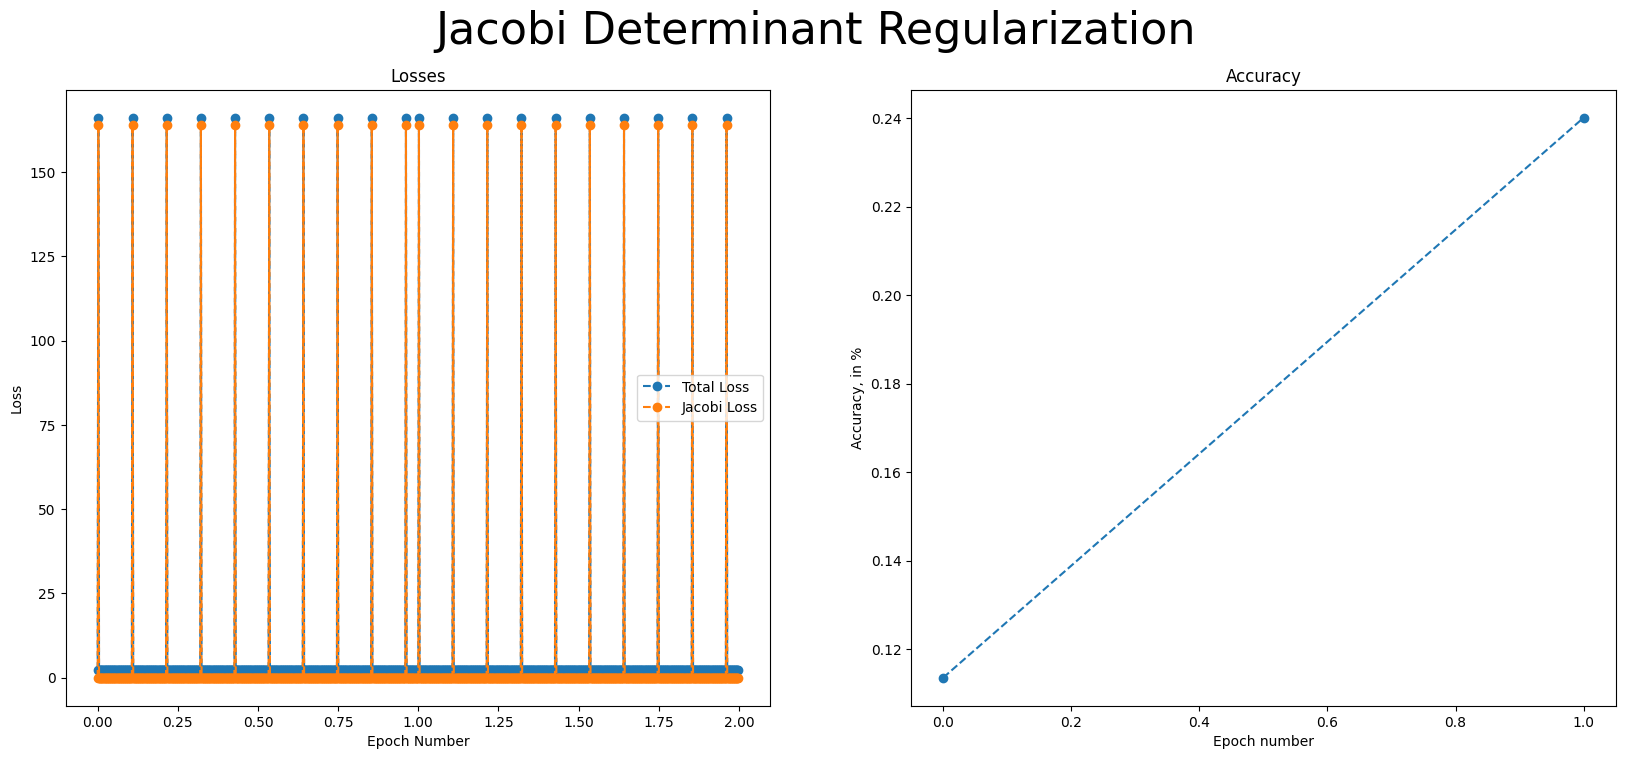

In [21]:
plot_jacobi_results(epochs, losses, jacobi_losses, accuracies, title="Jacobi Determinant Regularization")